In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce
# import scrublet as scr
# import muon as mu
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import re

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '241021_BLD_integrate'
# input_table = '../data/231009_PBMC_HH514.csv'

results_file_base = '/vast/palmer/pi/hafler/yy693/ASAP/scanpy/241006_scvi_BLD_doublet0.15_addribo_removelowribo_chem/241006_scvi_BLD_doublet0.15_addribo_removelowribo_chem.celltypist.scrubletall.h5ad'
results_file = f'../scanpy/{version}/{version}.h5ad'
results_file_cellxgene = f'../scanpy/{version}/{version}.cxg.h5ad'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

2024-10-28 10:56:44.419718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 10:56:44.435928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 10:56:44.452847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 10:56:44.457337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 10:56:44.471636: I tensorflow/core/platform/cpu_feature_guar

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [6]:
adata = sc.read(results_file_base)

Only considering the two last: ['.scrubletall', '.h5ad'].
Only considering the two last: ['.scrubletall', '.h5ad'].


In [7]:
adata

AnnData object with n_obs × n_vars = 528786 × 26640
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Diagnosis', 'Gender', 'Age', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Ye

In [8]:
f_cluster_L1 = '/vast/palmer/pi/hafler/yy693/ASAP/scanpy/241006_scvi_BLD_doublet0.15_addribo_removelowribo_chem/241015.csv'
df_clu = pd.read_csv(f_cluster_L1, skiprows=2, index_col=0)
adata.obs = pd.merge(adata.obs, df_clu, left_index=True, right_index=True, how='left')

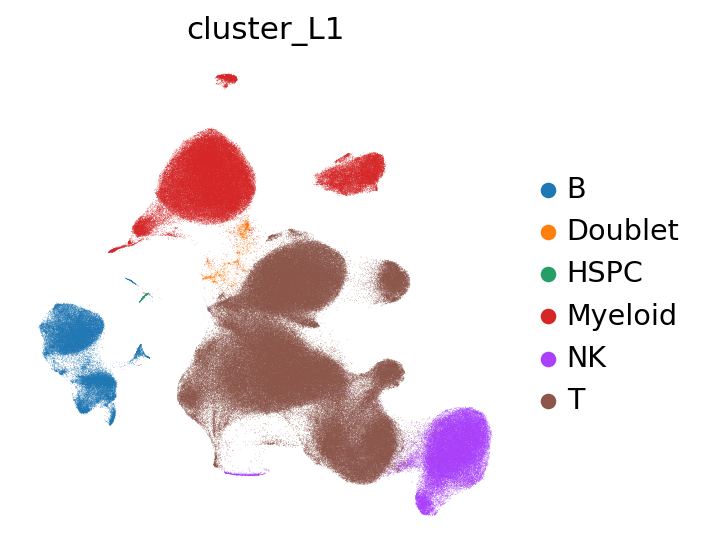

In [9]:
sc.pl.umap(adata, color='cluster_L1', save='base_cluster_L1.pdf')

In [10]:
list_f_cluster_L2 = ['/vast/palmer/pi/hafler/yy693/ASAP/scanpy/241010_scvi_BLD_subcluster_myelo/241015.csv',
'/vast/palmer/pi/hafler/yy693/ASAP/scanpy/241010_scvi_BLD_subcluster_B/241015.csv',
'/vast/palmer/pi/hafler/yy693/ASAP/scanpy/241010_scvi_BLD_subcluster_NK/241015.csv',
'/vast/palmer/pi/hafler/yy693/ASAP/scanpy/241010_scvi_BLD_subcluster_T/241015.csv',
]

In [11]:
df_clu = pd.concat([pd.read_csv(f, skiprows=2, index_col=0) for f in list_f_cluster_L2])
adata.obs = pd.merge(adata.obs, df_clu, left_index=True, right_index=True, how='left')

In [12]:
adata

AnnData object with n_obs × n_vars = 528786 × 26640
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Diagnosis', 'Gender', 'Age', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Ye

In [13]:
adata.obs['cluster_L2'].unique()

array(['CD8CD4 Temra', 'CD14 Mono', 'CD8 Tem', 'B memory', 'B naive',
       'CD16 Mono', 'NK CD16', 'Treg', 'cDC2', 'CD4 Tcm', 'CD4 Tem',
       'Tgd', 'CD4 Tnaive', 'ASC', 'pDC', 'NK Cycling', 'ABC', 'NK CD56',
       'T Cycling', 'MAIT', 'Doublet', nan, 'cDC1', 'CD8 Tnaive',
       'CD16 Mono C1', 'Low Gene Exp'], dtype=object)

In [14]:
adata.obs.loc[adata.obs['cluster_L2'].isna(), 'cluster_L2'] = adata.obs.loc[adata.obs['cluster_L2'].isna(), 'cluster_L1']

In [15]:
adata.obs['cluster_L2'].unique()

array(['CD8CD4 Temra', 'CD14 Mono', 'CD8 Tem', 'B memory', 'B naive',
       'CD16 Mono', 'NK CD16', 'Treg', 'cDC2', 'CD4 Tcm', 'CD4 Tem',
       'Tgd', 'CD4 Tnaive', 'ASC', 'pDC', 'NK Cycling', 'ABC', 'NK CD56',
       'T Cycling', 'MAIT', 'Doublet', 'HSPC', 'cDC1', 'CD8 Tnaive',
       'CD16 Mono C1', 'Low Gene Exp'], dtype=object)

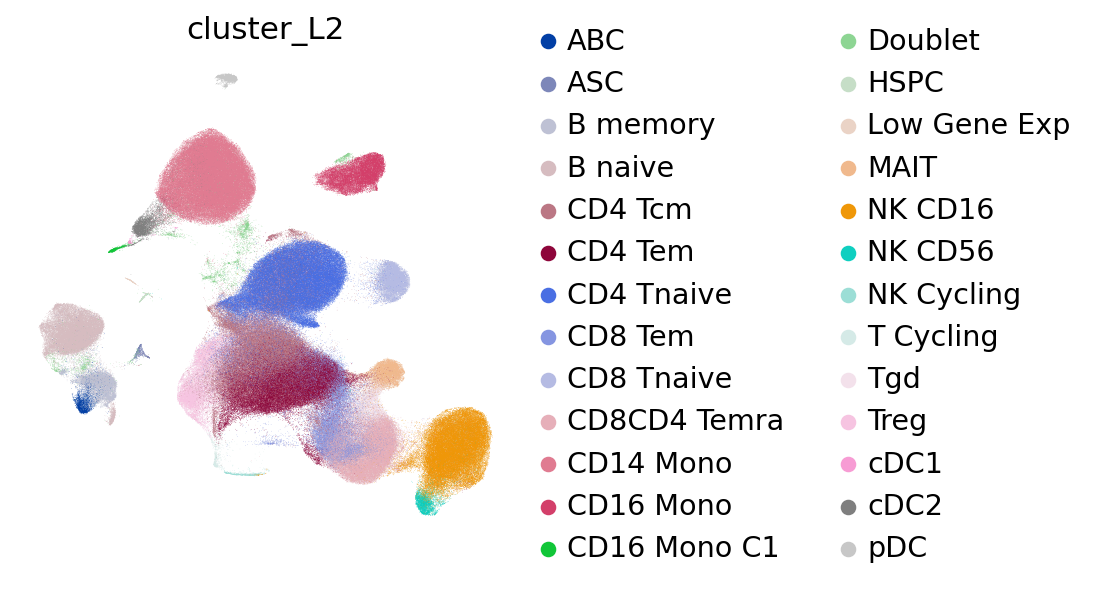

In [16]:
sc.pl.umap(adata, color='cluster_L2', save='base_cluster_L2.pdf')

In [17]:
adata = adata[~adata.obs['cluster_L2'].isin(['Doublet', 'Low Gene Exp'])].copy()

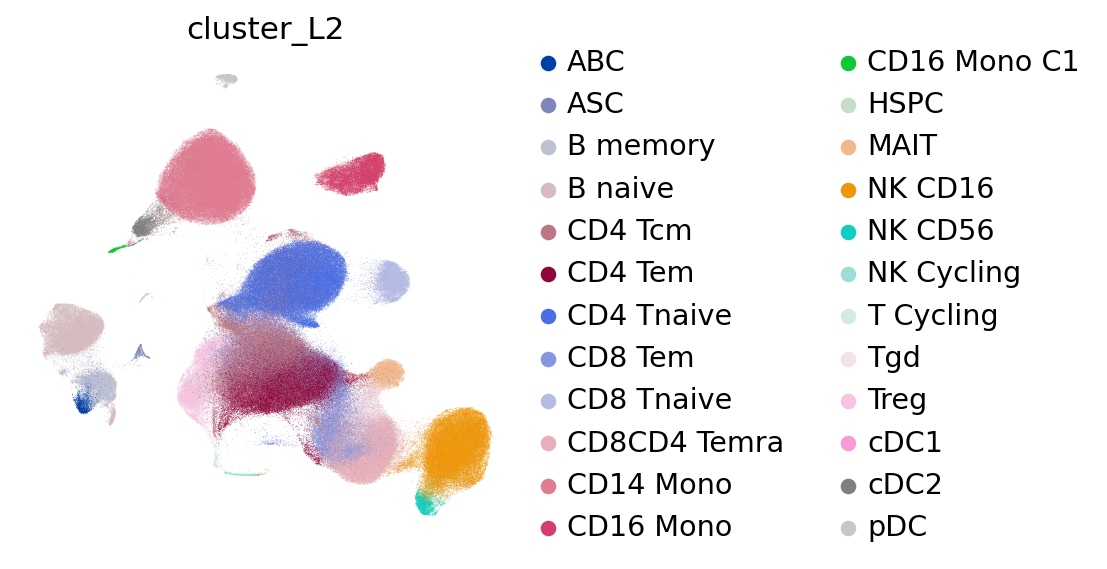

In [18]:
sc.pl.umap(adata, color='cluster_L2', save='filter_cluster_L2.pdf')

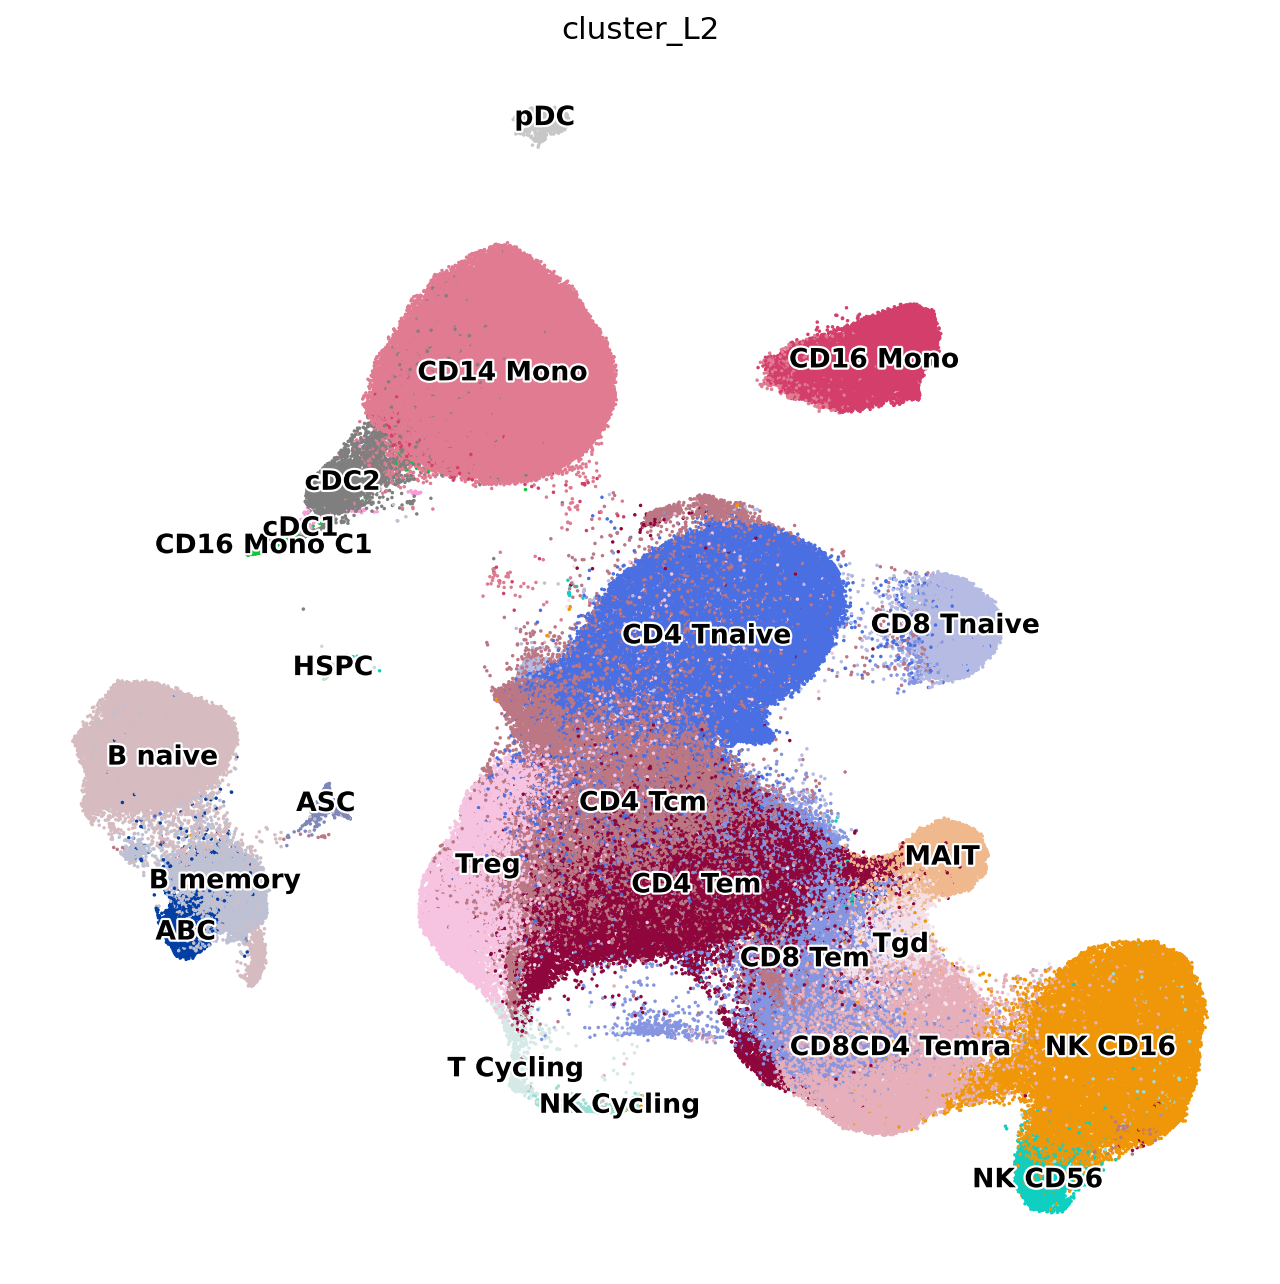

In [19]:
with mpl.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.umap(
        adata,
        color="cluster_L2",
        # add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        size=10,
        frameon=False,
        save='filter_cluster_L2.pdf'
    )

In [20]:
adata

AnnData object with n_obs × n_vars = 523521 × 26640
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Diagnosis', 'Gender', 'Age', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Ye

In [21]:
sc.pp.neighbors(adata, use_rep='X_scVI', n_neighbors=30)
adata.obsm['X_umap_filtered'] = sc.tl.umap(adata, min_dist=0.3, spread=1, copy=True).obsm['X_umap']

computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:12:31)


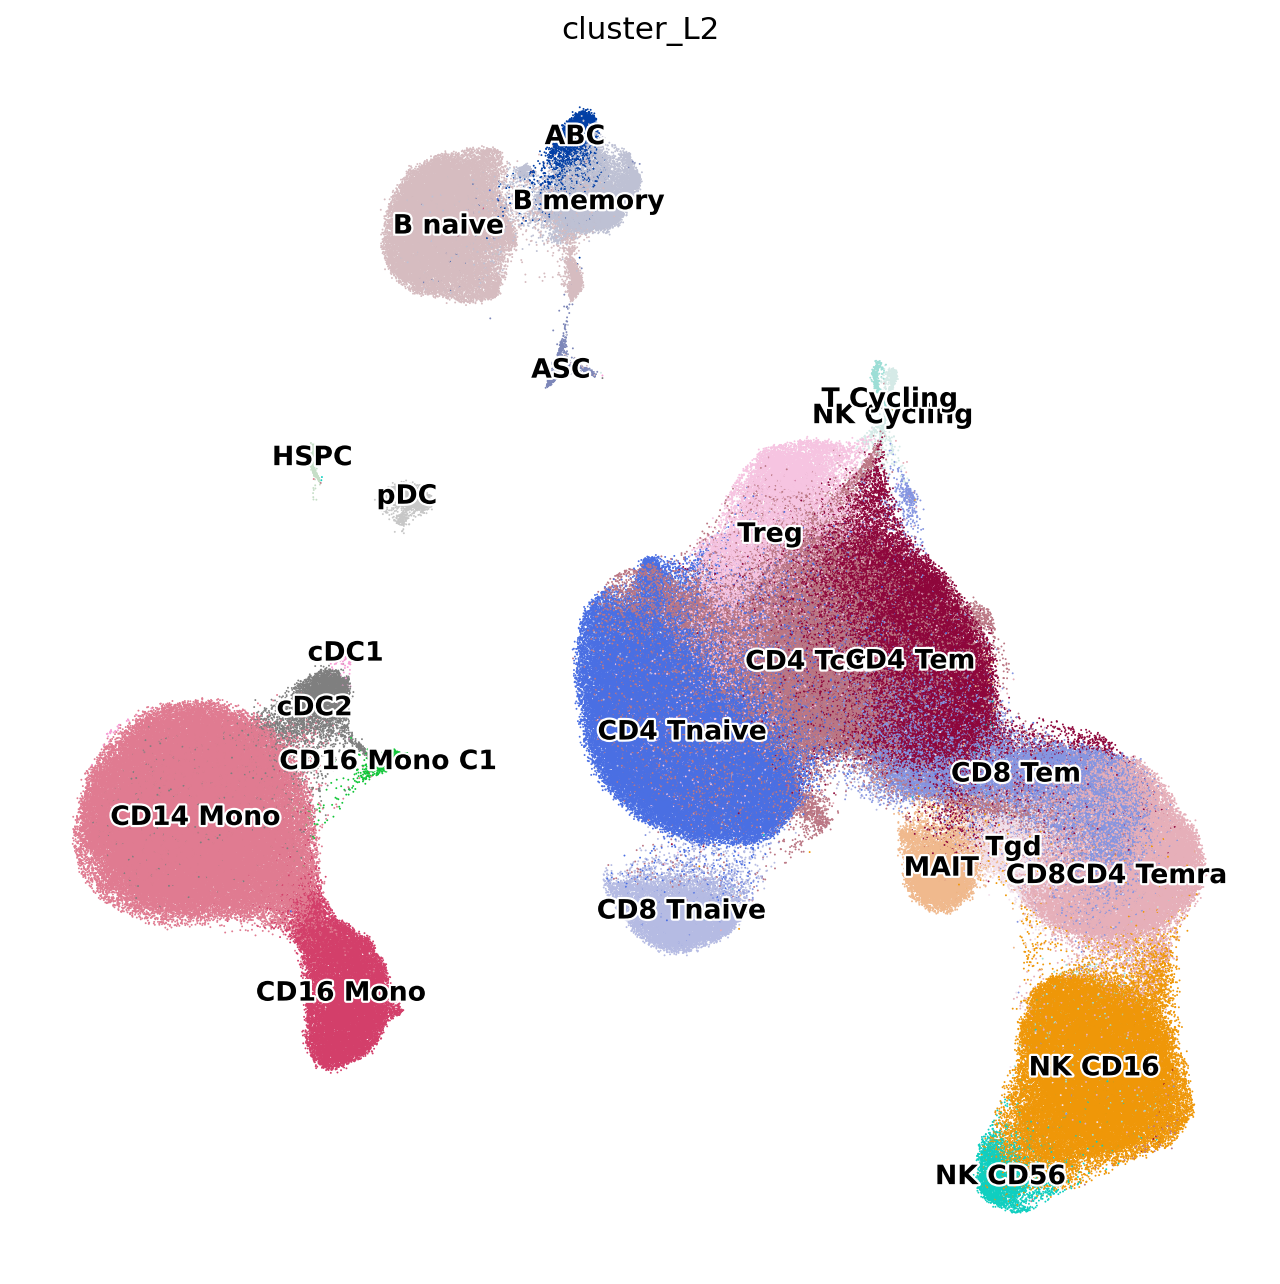

In [22]:
with mpl.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.embedding(
        adata,
        basis="umap_filtered",
        s=3,
        color="cluster_L2",
        # add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        size=10,
        frameon=False,
        save='filter_reembed_cluster_L2.pdf'
    )

In [40]:
adata.obs['cluster_L2'].cat.categories

Index(['ABC', 'ASC', 'B memory', 'B naive', 'CD4 Tcm', 'CD4 Tem', 'CD4 Tnaive',
       'CD8 Tem', 'CD8 Tnaive', 'CD8CD4 Temra', 'CD14 Mono', 'CD16 Mono',
       'CD16 Mono C1', 'HSPC', 'MAIT', 'NK CD16', 'NK CD56', 'NK Cycling',
       'T Cycling', 'Tgd', 'Treg', 'cDC1', 'cDC2', 'pDC'],
      dtype='object')

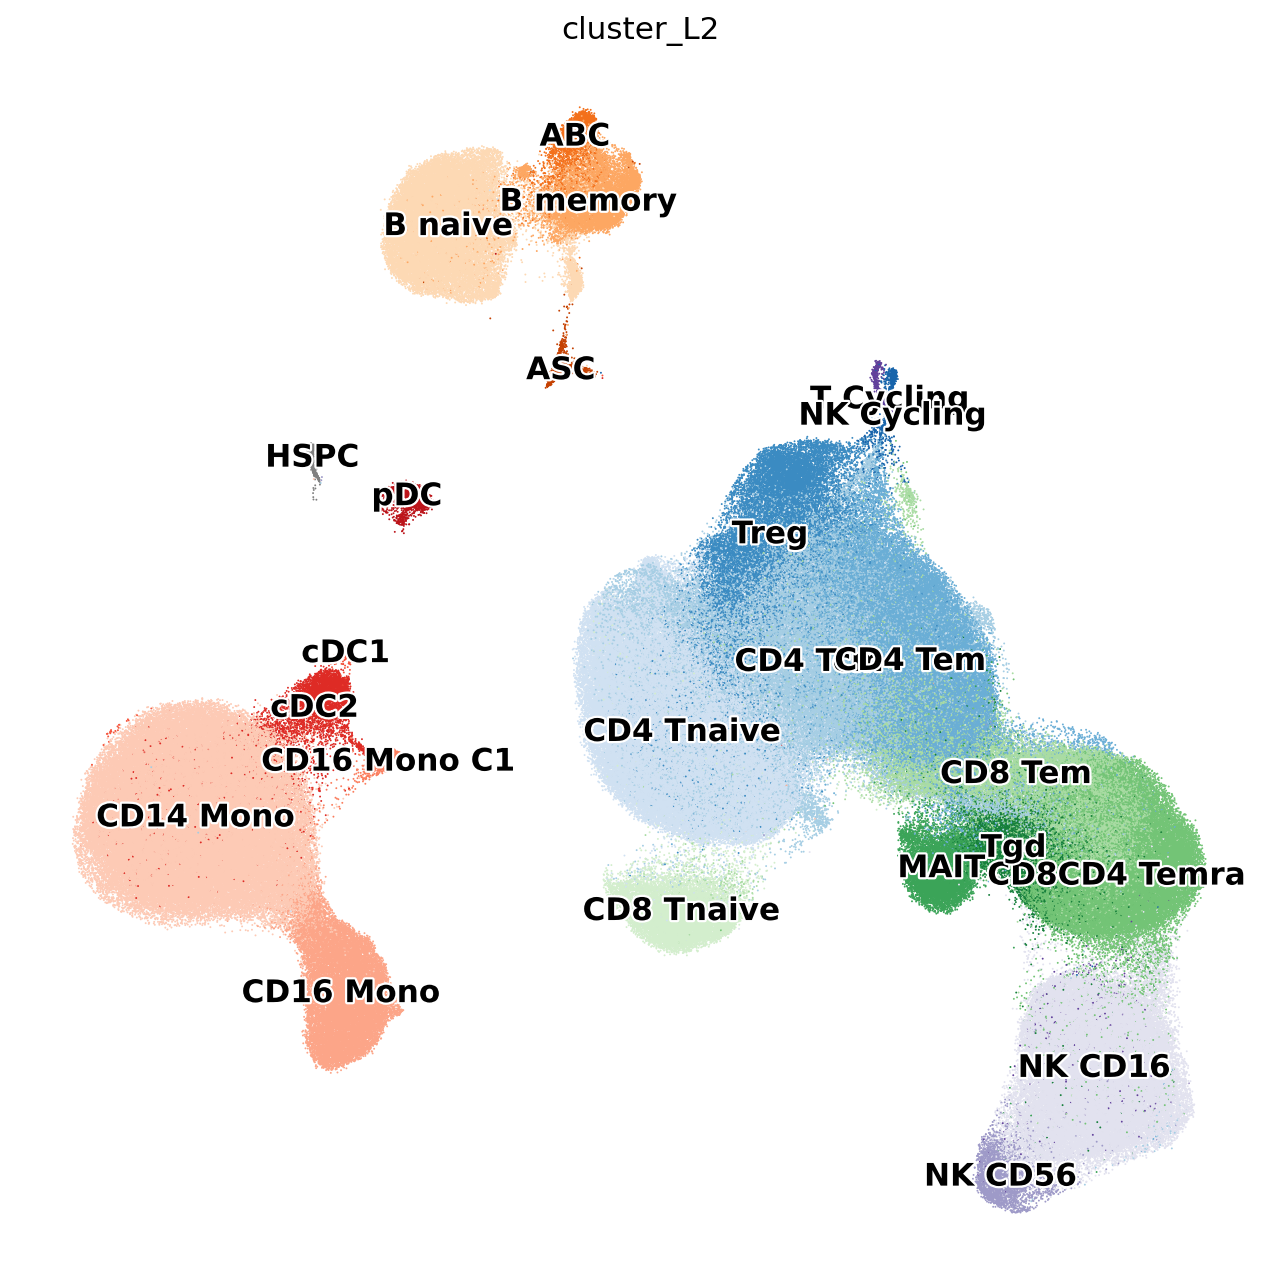

In [59]:
cluster_names = ['B naive', 'B memory', 'ABC', 'ASC', 
                'CD4 Tnaive', 'CD4 Tcm', 'CD4 Tem', 'Treg', 
                'CD8 Tnaive', 'CD8 Tem',  'CD8CD4 Temra', 
                 'MAIT', 'T Cycling', 'Tgd', 
                 'NK CD16', 'NK CD56', 'NK Cycling',
                'CD14 Mono', 'CD16 Mono',
                 'CD16 Mono C1', 
                 'cDC1', 'cDC2', 'pDC',
                 'HSPC']
adata.obs['cluster_L2'] = adata.obs['cluster_L2'].astype(pd.CategoricalDtype(categories=cluster_names, ordered=True))

cluster_colormap = {
    'ABC': 'Oranges', 'ASC': 'Oranges', 'B memory': 'Oranges', 'B naive': 'Oranges',
    'CD4 Tcm': 'Blues', 'CD4 Tem': 'Blues', 'CD4 Tnaive': 'Blues',
    'CD8 Tem': 'Greens', 'CD8 Tnaive': 'Greens', 'CD8CD4 Temra': 'Greens',
    'CD14 Mono': 'Reds', 'CD16 Mono': 'Reds', 'CD16 Mono C1': 'Reds',
    'HSPC': 'gray', 'MAIT': 'Greens', 
    'NK CD16': 'Purples', 'NK CD56': 'Purples', 'NK Cycling': 'Purples',
    'T Cycling': 'Blues', 'Tgd': 'Greens', 'Treg': 'Blues',
    'cDC1': 'Reds', 'cDC2': 'Reds', 'pDC': 'Reds'
}

def sample_cmap(cmap_name, num_samples, start=0.2, end=0.8):
    if cmap_name == 'gray':
        return ['gray'] * num_samples  
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i) for i in np.linspace(start, end, num_samples)]


def generate_cluster_palette(cluster_names, cluster_colormap):
    unique_cmap_counts = {color: 0 for color in set(cluster_colormap.values())}
    
    for cluster in cluster_names:
        colormap = cluster_colormap[cluster]
        unique_cmap_counts[colormap] += 1

    cmap_palettes = {}
    for colormap, count in unique_cmap_counts.items():
        cmap_palettes[colormap] = sample_cmap(colormap, count)
    
    cluster_palette = []
    cmap_counters = {color: 0 for color in set(cluster_colormap.values())}
    for cluster in cluster_names:
        colormap = cluster_colormap[cluster]
        cluster_palette.append(cmap_palettes[colormap][cmap_counters[colormap]])
        cmap_counters[colormap] += 1

    return cluster_palette

cluster_palette = generate_cluster_palette(cluster_names, cluster_colormap)

with plt.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.embedding(
        adata,
        basis="umap_filtered",
        s=3,
        color="cluster_L2",
        legend_loc="on data",
        legend_fontsize=14,
        legend_fontoutline=2,
        frameon=False,
        # add_outline=True,
        # outline_width=(0.1, 5),
        # palette=cluster_palette,
        save='filter_reembed_cluster_L2_color_gradation.pdf'
    )

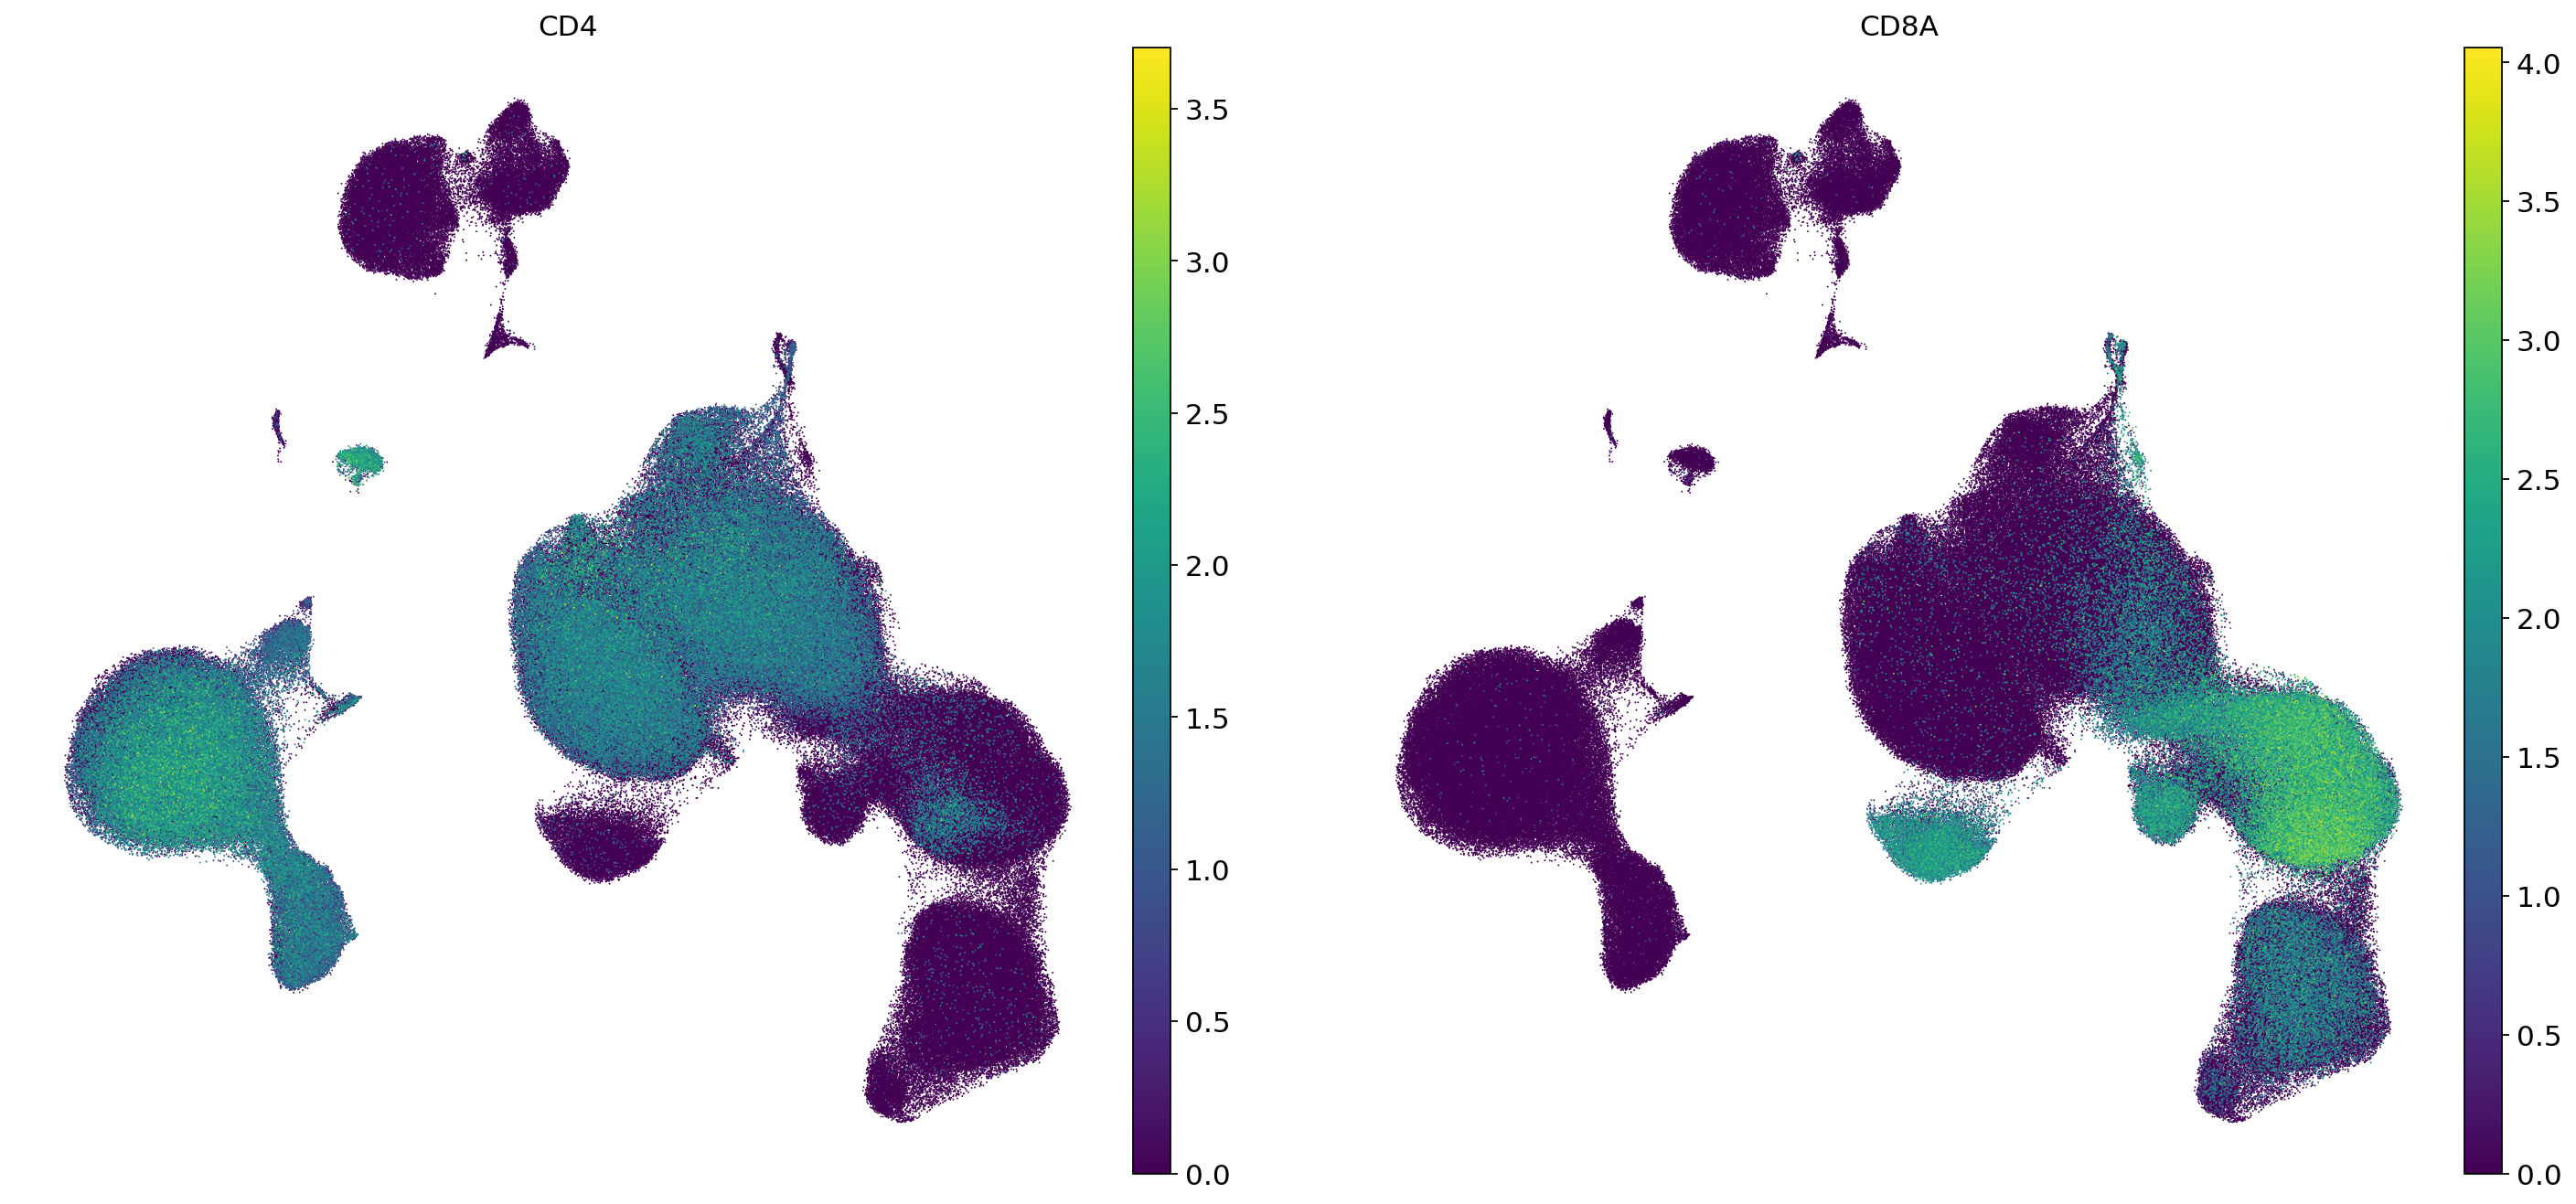

In [23]:
with mpl.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.embedding(
        adata,
        basis="umap_filtered",
        s=3,
        color=["CD4", 'CD8A']
    )